# MCDropout BNN for a regression task


For more information on this BNN implementation, see https://arxiv.org/pdf/1703.04977.pdf

## Setup

In [1]:
!pip install concretedropout

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import tensorflow as tf
import keras.backend as K
from tensorflow import keras
from tensorflow.keras import layers
from concretedropout.tensorflow import ConcreteDenseDropout, get_weight_regularizer, get_dropout_regularizer

## Prepare the data

In [3]:
Q = 1
D = 1

def gen_data(N):
    sigma = 1e0  # ground truth
    X = np.random.randn(N, Q)
    w = 2.
    b = 8.
    Y = X.dot(w) + b + sigma * np.random.randn(N, D)
    return X, Y

In [4]:
x_train, y_train = gen_data(1000)
x_test, y_test = gen_data(100)

input_shape = (1,)

## BNN model

In [5]:
@tf.function
def heteroscedastic_loss(y_true, y_pred):
    D = y_pred.shape[-1]//2
    mean = y_pred[:, :D]
    log_var = y_pred[:, D:]
    precision = tf.math.exp(-log_var)
    return tf.math.reduce_sum(precision * (y_true - mean)**2. + log_var)

In [6]:
# compute the regularisation values
Ns = x_train.shape[0]
wr = get_weight_regularizer(Ns, l=1e-2, tau=1.0)
dr = get_dropout_regularizer(Ns, tau=1.0, cross_entropy_loss=False)

# create the neural network
inputs = tf.keras.layers.Input(input_shape, name="inputs")

dense1 = layers.Dense(100)
x = dense1(inputs)
x = layers.Activation("relu", name="activation_1")(x)

dense2 = layers.Dense(100)
x = ConcreteDenseDropout(dense2, is_mc_dropout=True, weight_regularizer=wr, dropout_regularizer=dr)(x)
x = layers.Activation("relu", name="activation_2")(x)

dense3 = layers.Dense(100)
x = ConcreteDenseDropout(dense3, is_mc_dropout=True, weight_regularizer=wr, dropout_regularizer=dr)(x)
x = layers.Activation("relu", name="activation_3")(x)

dense_mean = layers.Dense(1)
mean = ConcreteDenseDropout(dense_mean, is_mc_dropout=True, weight_regularizer=wr, dropout_regularizer=dr)(x)

dense_logvar = layers.Dense(1)
logvar = ConcreteDenseDropout(dense_logvar, is_mc_dropout=True, weight_regularizer=wr, dropout_regularizer=dr)(x)

concat = tf.keras.layers.Concatenate(axis=-1)([mean, logvar]) 
outputs = layers.Activation("linear", name="out")(concat)

model = tf.keras.Model(inputs=inputs, outputs=outputs, name="regression_model")

model.summary()

Model: "regression_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 1)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 100)          200         ['inputs[0][0]']                 
                                                                                                  
 activation_1 (Activation)      (None, 100)          0           ['dense[0][0]']                  
                                                                                                  
 concrete_dense_dropout (Concre  (None, 100)         10101       ['activation_1[0][0]']           
 teDenseDropout)                                                                   

In [7]:
from tqdm.auto import tqdm

def MC_predict( model, X, Y_dim=1, n_samples=1000, verbose=False, **kwargs):
    mean_arr = []
    std_dev_arr = []
    shape = X.shape
    if verbose:
        iterator = tqdm(np.arange(shape[0]))
    else:
        iterator = np.arange(shape[0])


    for i in iterator:
        X_in = tf.gather(X, i, axis=0)
        X_in = tf.reshape(X_in, (1, *shape[1:]))
        X_in = tf.repeat(X_in, n_samples, axis=0)


        predictions = model.predict(X_in, **kwargs)
        
        yhat = predictions[:, :Y_dim]
        logvars = predictions[:, Y_dim:]
  

        mean = np.mean(yhat, axis=0)
        
        y2 = np.mean(yhat**2, axis=0)
        y_m = mean
        var_mean = np.mean(np.exp(logvars), axis=0)
        total_var = y2 - y_m**2 + var_mean
        std_dev = np.sqrt(total_var)


        mean_arr.append(mean)
        std_dev_arr.append(std_dev)

    mean_arr = np.asarray(mean_arr)
    std_dev_arr = np.asarray(std_dev_arr)
    return mean_arr, std_dev_arr

### Train the model

In [8]:
batch_size = 128
epochs = 100

model.compile(loss=heteroscedastic_loss, optimizer="adam")

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1, verbose=0)

### Evaluate the trained model

Now we want to get the predictive distribution for the test samples and plot it

In [9]:
import matplotlib.pyplot as plt

In [10]:
y_pred, std = MC_predict(model, x_test, verbose=True)

  0%|          | 0/100 [00:00<?, ?it/s]

In [11]:
argsort = np.argsort(x_test, axis=0)
x_sorted = x_test[argsort].reshape(-1)
y_pred_sorted = y_pred[argsort].reshape(-1)
y_true_sorted = y_test[argsort].reshape(-1)
std_sorted = std[argsort].reshape(-1)

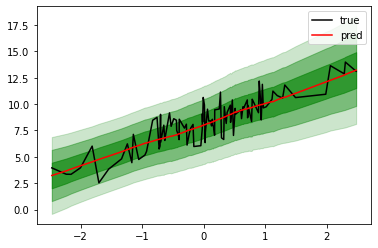

In [12]:
plt.fill_between(x_sorted, y_pred_sorted-3*std_sorted, y_pred_sorted+3*std_sorted, alpha=0.2, color="green")
plt.fill_between(x_sorted, y_pred_sorted-2*std_sorted, y_pred_sorted+2*std_sorted, alpha=0.4, color="green")
plt.fill_between(x_sorted, y_pred_sorted-std_sorted, y_pred_sorted+std_sorted, alpha=0.6, color="green")
plt.plot(x_sorted, y_true_sorted, label="true", color="black")
plt.plot(x_sorted, y_pred_sorted, label="pred", color="red")
plt.legend()
plt.show()

get the dropout values:

In [13]:
ps = np.array([K.eval(layer.p_logit) for layer in model.layers if hasattr(layer, 'p_logit')])
droput_val = tf.nn.sigmoid(ps).numpy()
print(droput_val)

[[0.06972548]
 [0.06403305]
 [0.05817999]
 [0.08279803]]
